# TRAINING MODELS

[Preparation](##-PREPARING-DATA)

[Models](#-THE-MODELS)

[Conclusion](#-CONCLUSION)

## PREPARING DATA

This is the last step of the project. After preparing the data, we fit it into the models, train them, select the best one, and make predictions on the unlabeled data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./df_clean.csv')
df.head()

,Tuition,FRP_Active,FRP_Cancelled,FRP_Take_up_percent_,EZ_Pay_Take_Up_Rate,School_Sponsor,SPR_Group_Revenue,FPP_to_PAX,Num_of_Non_FPP_PAX,ID_TRIP,...,Cancellation_Rate,Revenue_per_PAX,Deposit_Ratio,Insurance_Cancellation_Rate,Months_to_Departure,Past_Bookings,Initial_Year,Initial_Season,Grade_Span,Departure_Season
0,397,1,1,0.020913,0.017856,1,447,0.967036,2,1389,...,0.096774,7.982143,7.089286,1.000000,6,40.0,2018,1,1.0,2
1,563,0,0,0.600876,0.217302,0,579,0.993127,1,3090,...,0.000000,13.159091,12.795455,0.181818,5,89.0,2018,2,0.0,2
2,617,0,0,0.600876,0.217302,0,529,0.973946,1,3639,...,0.000000,11.020833,12.854167,0.181818,6,92.0,2018,2,0.0,2
3,446,1,1,0.019032,0.019285,1,381,0.981972,2,4249,...,0.107143,7.620000,8.920000,1.000000,7,26.0,2018,1,1.0,2
4,582,15,11,0.597237,0.035036,1,596,0.963426,2,1021,...,0.500000,24.833333,24.250000,0.733333,6,65.0,2018,1,0.0,2


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4125 entries, 0 to 4124
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Tuition                                4125 non-null   int64  
 1   FRP_Active                             4125 non-null   int64  
 2   FRP_Cancelled                          4125 non-null   int64  
 3   FRP_Take_up_percent_                   4125 non-null   float64
 4   EZ_Pay_Take_Up_Rate                    4125 non-null   float64
 5   School_Sponsor                         4125 non-null   int64  
 6   SPR_Group_Revenue                      4125 non-null   int64  
 7   FPP_to_PAX                             4125 non-null   float64
 8   Num_of_Non_FPP_PAX                     4125 non-null   int64  
 9   ID_TRIP                                4125 non-null   int64  
 10  ID_SALES                               4125 non-null   object 
 11  Prog

First of all, we apply the get_dummies function to the categorical variables in order to make them suitable for the models.

In [24]:
df = pd.get_dummies(df, columns = ['Program_Code'], drop_first=True)
df['Group_State_encoded'] = df['Group_State'].map(df['Group_State'].value_counts(normalize=True))
df = df.drop(columns=['Group_State'])
df = pd.get_dummies(df, columns=['Travel_Type'], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=['SPR_Product_Type'], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=['MajorProgramCode'], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=['Region'], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=['School_Type'], dtype=int, drop_first=True)

Then, we define the target variable (‘Retained’), standardize the data, and split it into training and test sets.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import GridSearchCV

target = "Retained"  

# Keep Only Numeric Features (Remove categorical variables such as IDs)
df_clean = df.select_dtypes(include=['number']).copy()

# Define Features (X) and Target (y)
X = df_clean.drop(columns=[target])
y = df_clean[target]

# Split (80%/20%) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardization 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In our classification problem, the primary goal is to predict whether a specific school trip will be booked again next year. While accuracy is a common metric in classification tasks, in our case it does not fully capture the business impact of prediction errors.

Specifically, we want to avoid predicting that a trip will be rebooked when, in fact, it won’t (a false positive). This type of error leads to unnecessary planning, resource allocation, and organizational efforts for a trip that ultimately does not take place. From a practical and cost-related perspective, this is more problematic than missing out on a trip that would have been rebooked (a false negative).

Therefore, our objective is to **maximize Precision**, ensuring that when the model predicts a trip will be rebooked, it is highly likely to be correct. We are willing to accept a lower Recall as a trade-off, as long as the positive predictions made by the model are reliable. This justifies our use of the F0.5 score as the optimization metric, which puts more weight on Precision than Recall:

$$F_{0.5} = (1 + 0.5^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{(0.5^2 \cdot \text{Precision}) + \text{Recall}} = 1.25 \cdot \frac{\text{Precision} \cdot \text{Recall}}{0.25 \cdot \text{Precision} + \text{Recall}}$$

Moreover, our dataset is not perfectly balanced (approximately 60% of Ones and 40% of Zeros), which further reinforces that high accuracy might be misleading. Precision is a more meaningful metric for evaluating our model’s performance.

We'll train the models using Dual Tresholds: "normal" ($0.5$), as a baseline for model performance under balanced conditions, and adjusted ($0.6$), in order to increase Precision by requiring stronger evidence to predict "Retained" (Class 1).

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score, classification_report, confusion_matrix

# THE MODELS

## -RANDOM FOREST

In [27]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=42)

# F0.5 
f05_scorer = make_scorer(fbeta_score, beta=0.5)

# Parameters
parameters = {   
    'n_estimators': [100, 200],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'criterion': ['gini'],
    'bootstrap': [True, False], 
    'max_features': ['log2', 'sqrt']
}

# GridSearchCV 
gs = GridSearchCV(classifier, parameters, cv=5, scoring=f05_scorer, verbose=10, n_jobs=-1)
gs.fit(X_train, y_train)

# Best model
best_model_forest = gs.best_estimator_

# Prediction
y_pred = best_model_forest.predict(X_test)

# Prediction with treshold 0.6 to reduce FPs
y_probs = best_model_forest.predict_proba(X_test)[:, 1]  
new_threshold = 0.6 
y_pred_adjusted = (y_probs > new_threshold).astype(int)



# Results
print("\n*** GRIDSEARCH RESULTS ***")
print(f"Best parameters: {gs.best_params_}")

print("\n*** MODEL EVALUATION (Default Threshold) ***")
print(f"F0.5 Score: {fbeta_score(y_test, y_pred, beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\n*** MODEL EVALUATION (Adjusted Threshold) ***")
print(f"F0.5 Score (Adjusted): {fbeta_score(y_test, y_pred_adjusted, beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_adjusted))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 3/5; 1/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 2/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 5/5; 1/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 2/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/5; 1/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 1/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 2/8] START bootstrap=True, criterion=gini, max_depth=None, ma

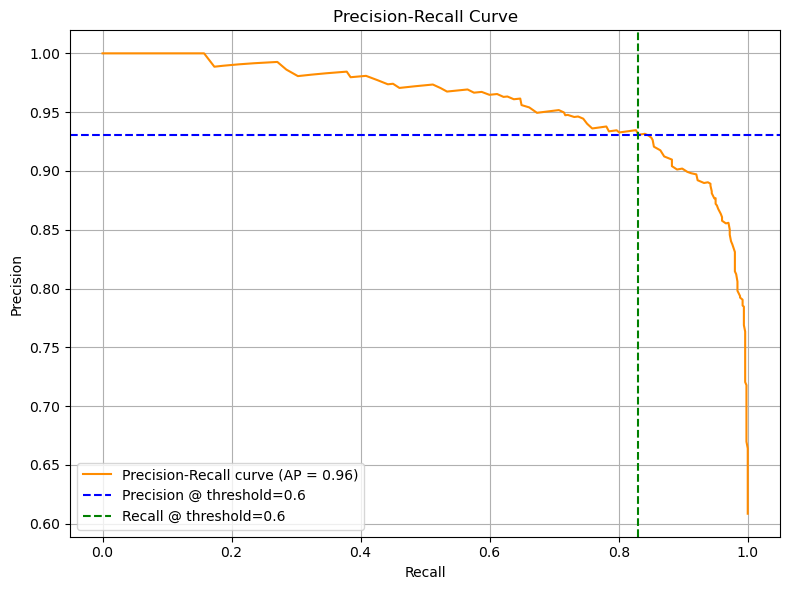

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.2f})', color='darkorange')
plt.axhline(y=precision[np.argmax(thresholds >= new_threshold)], color='blue', linestyle='--', label=f'Precision @ threshold={new_threshold}')
plt.axvline(x=recall[np.argmax(thresholds >= new_threshold)], color='green', linestyle='--', label=f'Recall @ threshold={new_threshold}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

The curve maintains high precision across a wide range of recall values, indicating strong performance in distinguishing between classes. \
This threshold achieves a good balance, aligning with the project’s goal of prioritizing precision over recall, as reflected in the use of the F0.5-score as the main evaluation metric.

## -XGB

In [29]:
from xgboost import XGBClassifier


# Model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', verbosity=0)

# Parameters
params_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# F0.5
f05_scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search
gs_xgb = GridSearchCV(xgb, params_xgb, cv=5, scoring=f05_scorer, n_jobs=-1, verbose=10)
gs_xgb.fit(X_train, y_train)

# Best model
best_xgb = gs_xgb.best_estimator_

# Prediction
y_probs_xgb = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_probs_xgb > 0.6).astype(int)

# Prediction with treshold 0.6 
y_probs = best_xgb.predict_proba(X_test)[:, 1]  
new_threshold = 0.6 
y_pred_adjusted = (y_probs > new_threshold).astype(int)



# Results
print("\n*** GRIDSEARCH RESULTS ***")
print(f"Best parameters: {gs_xgb.best_params_}")  

print("\n*** MODEL EVALUATION (Default Threshold=0.5) ***")
y_pred_default = best_xgb.predict(X_test)  
print(f"F0.5 Score: {fbeta_score(y_test, y_pred_default, beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_default))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_default))

print("\n*** MODEL EVALUATION (Adjusted Threshold=0.6) ***")
print(f"F0.5 Score: {fbeta_score(y_test, y_pred_adjusted, beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_adjusted))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 2/5; 1/32] START colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
[CV 1/5; 1/32] START colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
[CV 3/5; 1/32] START colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
[CV 4/5; 1/32] START colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
[CV 1/5; 2/32] START colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1
[CV 2/5; 2/32] START colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1
[CV 5/5; 1/32] START colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
[CV 3/5; 2/32] START colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1
[CV 3/5; 1/32] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=10

## -LOGISTIC REGRESSION

In [30]:
from sklearn.linear_model import LogisticRegression

# Model
logreg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

# Parameters
params_log = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Grid Search
gs_log = GridSearchCV(logreg, params_log, cv=5, scoring=f05_scorer, n_jobs=-1, verbose=10)
gs_log.fit(X_train, y_train)

# Best model
best_log = gs_log.best_estimator_

# Predictions
y_probs_log = best_log.predict_proba(X_test)[:, 1]
y_pred_log = (y_probs_log > 0.6).astype(int)

# Prediction with treshold 0.6 
y_probs = best_xgb.predict_proba(X_test)[:, 1]  
new_threshold = 0.6 
y_pred_adjusted = (y_probs > new_threshold).astype(int)


# Results
print("\n*** GRIDSEARCH RESULTS ***")
print(f"Best parameters: {gs_log.best_params_}") 

print("\n*** MODEL EVALUATION (Default Threshold=0.5) ***")
y_pred_default = best_log.predict(X_test)  
print(f"F0.5 Score: {fbeta_score(y_test, y_pred_default, beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_default))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_default))

print("\n*** MODEL EVALUATION (Adjusted Threshold=0.6) ***")
y_probs_log = best_log.predict_proba(X_test)[:, 1] 
y_pred_adjusted = (y_probs_log > 0.6).astype(int)  
print(f"F0.5 Score: {fbeta_score(y_test, y_pred_adjusted, beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_adjusted))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 2/5; 1/6] START C=0.1, penalty=l1...........................................
[CV 1/5; 1/6] START C=0.1, penalty=l1...........................................
[CV 3/5; 1/6] START C=0.1, penalty=l1...........................................
[CV 4/5; 1/6] START C=0.1, penalty=l1...........................................
[CV 5/5; 1/6] START C=0.1, penalty=l1...........................................
[CV 1/5; 2/6] START C=0.1, penalty=l2...........................................
[CV 2/5; 2/6] START C=0.1, penalty=l2...........................................
[CV 1/5; 1/6] END ............C=0.1, penalty=l1;, score=0.803 total time=   0.0s
[CV 3/5; 2/6] START C=0.1, penalty=l2...........................................
[CV 1/5; 2/6] END ............C=0.1, penalty=l2;, score=0.803 total time=   0.0s
[CV 4/5; 2/6] START C=0.1, penalty=l2...........................................
[CV 3/5; 1/6] END ............C=0.1, penalty=l1;,

## -Neural Network (MLP)

In [38]:
from sklearn.neural_network import MLPClassifier


# Model
mlp = MLPClassifier(random_state=42, max_iter=300)

# Parameters
params_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

# Grid Search
gs_mlp = GridSearchCV(mlp, params_mlp, cv=5, scoring=f05_scorer, n_jobs=-1, verbose=0)
gs_mlp.fit(X_train, y_train)

best_mlp = gs_mlp.best_estimator_

# Predictions
y_probs_mlp = best_mlp.predict_proba(X_test)[:, 1]
y_pred_mlp = (y_probs_mlp > 0.6).astype(int)

# Prediction with treshold 0.6 
y_probs = best_xgb.predict_proba(X_test)[:, 1]  
new_threshold = 0.6 
y_pred_adjusted = (y_probs > new_threshold).astype(int)


# Results
print("\n*** GRIDSEARCH RESULTS ***")
print(f"Best parameters: {gs_mlp.best_params_}") 

print("\n*** MODEL EVALUATION (Default Threshold) ***")
y_pred_default = best_mlp.predict(X_test)  # Using MLP's default threshold (0.5)
print(f"F0.5 Score: {fbeta_score(y_test, y_pred_default, beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_default))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_default))

print("\n*** MODEL EVALUATION (Adjusted Threshold=0.6) ***")
y_pred_adjusted = (y_probs_mlp > 0.6).astype(int)  # Using MLP's probabilities
print(f"F0.5 Score: {fbeta_score(y_test, y_pred_adjusted, beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_adjusted))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_


*** GRIDSEARCH RESULTS ***
Best parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}

*** MODEL EVALUATION (Default Threshold) ***
F0.5 Score: 0.8757
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81       323
           1       0.88      0.88      0.88       502

    accuracy                           0.85       825
   macro avg       0.84      0.84      0.84       825
weighted avg       0.85      0.85      0.85       825

Confusion Matrix:
 [[260  63]
 [ 61 441]]

*** MODEL EVALUATION (Adjusted Threshold=0.6) ***
F0.5 Score: 0.8802
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       323
           1       0.89      0.86      0.87       502

    accuracy                           0.85       825
   macro avg       0.84      0.84      0.84       825
weighted avg   

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


## -ADABOOST

In [32]:
from sklearn.ensemble import AdaBoostClassifier

# Model
ada = AdaBoostClassifier(random_state=42)

# Parameters
params_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Grid Search
gs_ada = GridSearchCV(ada, params_ada, cv=5, scoring=f05_scorer, n_jobs=-1, verbose=0)
gs_ada.fit(X_train, y_train)

# Best model
best_ada = gs_ada.best_estimator_

# Predictions
y_probs_ada = best_ada.predict_proba(X_test)[:, 1]
y_pred_ada = (y_probs_ada > 0.6).astype(int)

# Results
print("\n*** AdaBoost GRIDSEARCH RESULTS ***")
print(f"Best parameters: {gs_ada.best_params_}")

print("\n*** MODEL EVALUATION (Default Threshold) ***")
print(f"F0.5 Score: {fbeta_score(y_test, best_ada.predict(X_test), beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, best_ada.predict(X_test)))
print("Confusion Matrix:\n", confusion_matrix(y_test, best_ada.predict(X_test)))

print("\n*** MODEL EVALUATION (Adjusted Threshold=0.6) ***")
print(f"F0.5 Score: {fbeta_score(y_test, y_pred_ada, beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ada))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorith


*** AdaBoost GRIDSEARCH RESULTS ***
Best parameters: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}

*** MODEL EVALUATION (Default Threshold) ***
F0.5 Score: 0.7740
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.59      0.64       323
           1       0.76      0.84      0.80       502

    accuracy                           0.74       825
   macro avg       0.73      0.71      0.72       825
weighted avg       0.74      0.74      0.74       825

Confusion Matrix:
 [[189 134]
 [ 80 422]]

*** MODEL EVALUATION (Adjusted Threshold=0.6) ***
F0.5 Score: 0.6537
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.95      0.63       323
           1       0.91      0.31      0.46       502

    accuracy                           0.56       825
   macro avg       0.69      0.63      0.54       825
weighted avg       0.74      0.56      0.53       825

C

## -GRADIENT DESCENT

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

# Model
gbc = GradientBoostingClassifier(random_state=42)

# Parameters
params_gbc = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', None]
}

# Grid Search
gs_gbc = GridSearchCV(gbc, params_gbc, cv=5, scoring=f05_scorer, n_jobs=-1, verbose=10)
gs_gbc.fit(X_train, y_train)

# Best model
best_gbc = gs_gbc.best_estimator_

# Predictions
y_probs_gbc = best_gbc.predict_proba(X_test)[:, 1]
y_pred_gbc = (y_probs_gbc > 0.6).astype(int)

# Results
print("\n*** GradientBoosting GRIDSEARCH RESULTS ***")
print(f"Best parameters: {gs_gbc.best_params_}")

print("\n*** MODEL EVALUATION (Default Threshold) ***")
print(f"F0.5 Score: {fbeta_score(y_test, best_gbc.predict(X_test), beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, best_gbc.predict(X_test)))
print("Confusion Matrix:\n", confusion_matrix(y_test, best_gbc.predict(X_test)))

print("\n*** MODEL EVALUATION (Adjusted Threshold=0.6) ***")
print(f"F0.5 Score: {fbeta_score(y_test, y_pred_gbc, beta=0.5):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_gbc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gbc))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_split=2, n_estimators=100
[CV 2/5; 1/32] START learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_split=2, n_estimators=100
[CV 3/5; 1/32] START learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_split=2, n_estimators=100
[CV 4/5; 1/32] START learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_split=2, n_estimators=100
[CV 5/5; 1/32] START learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_split=2, n_estimators=100
[CV 1/5; 2/32] START learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_split=2, n_estimators=200
[CV 2/5; 2/32] START learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_split=2, n_estimators=200
[CV 3/5; 2/32] START learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_split=2, n_estimators=200
[CV 2/5; 1/32] END learning_rate=0.1, max_depth=3, max_fea

# CONCLUSION

Here are the results:


| **Model**            | **F0.5 Score (Threshold = 0.5)** | **F0.5 Score (Threshold = 0.6)** |
|----------------------|----------------------------------|----------------------------------|
| Random Forest        | 90.16%                            | 91.09%                            |
| XGB Classifier  | 87.45%                             | 87.67%                           |
| Logistic Regression       | 77.88%                             | 79.92%                            |
| MLP       | 87.57%                            | 88.02%                            |
| AdaBoost Classifier | 77.40% | 65.37% |
| GradientBoost Classifier | 85.72% | 86.68% |


The model with the best results is the **Random Forest**, with a Precision of 93% for class 1. We have 38 False Positives, so trips we'll invest in unnecessarily, and 86 False Negatives, so retainable trips we might miss (opportunity cost). Naturally, we are assuming that the cost of 86 missed opportunities is higher than the cost of 38 wasted efforts!

I modelli fanno piu fatica a minimizzare FP che FN (F2 93%)

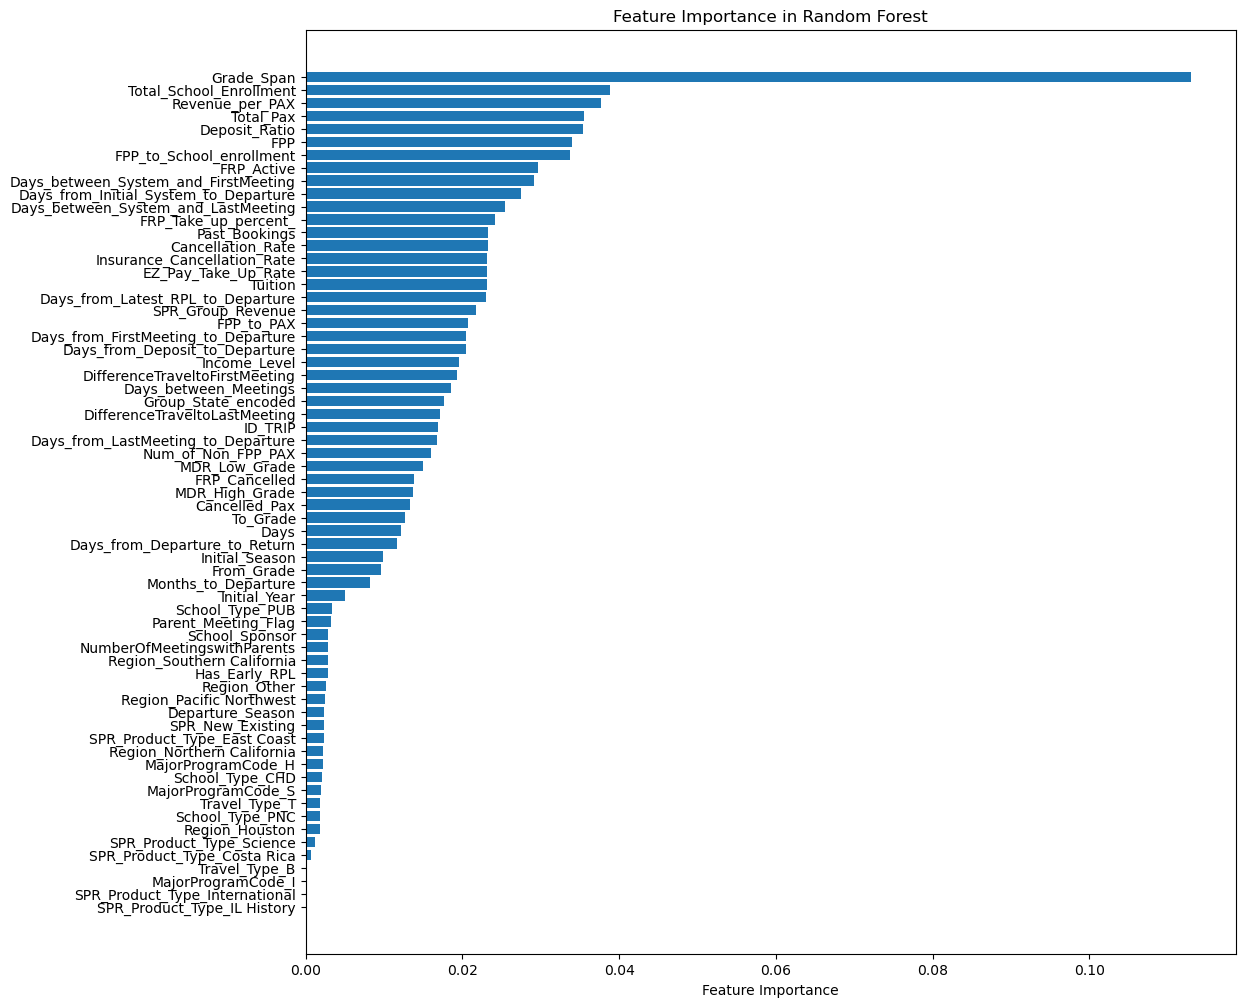

In [34]:
# Feature importance
feature_importances = best_model_forest.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest")
plt.show()

Let's give a look at the four most important features!

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

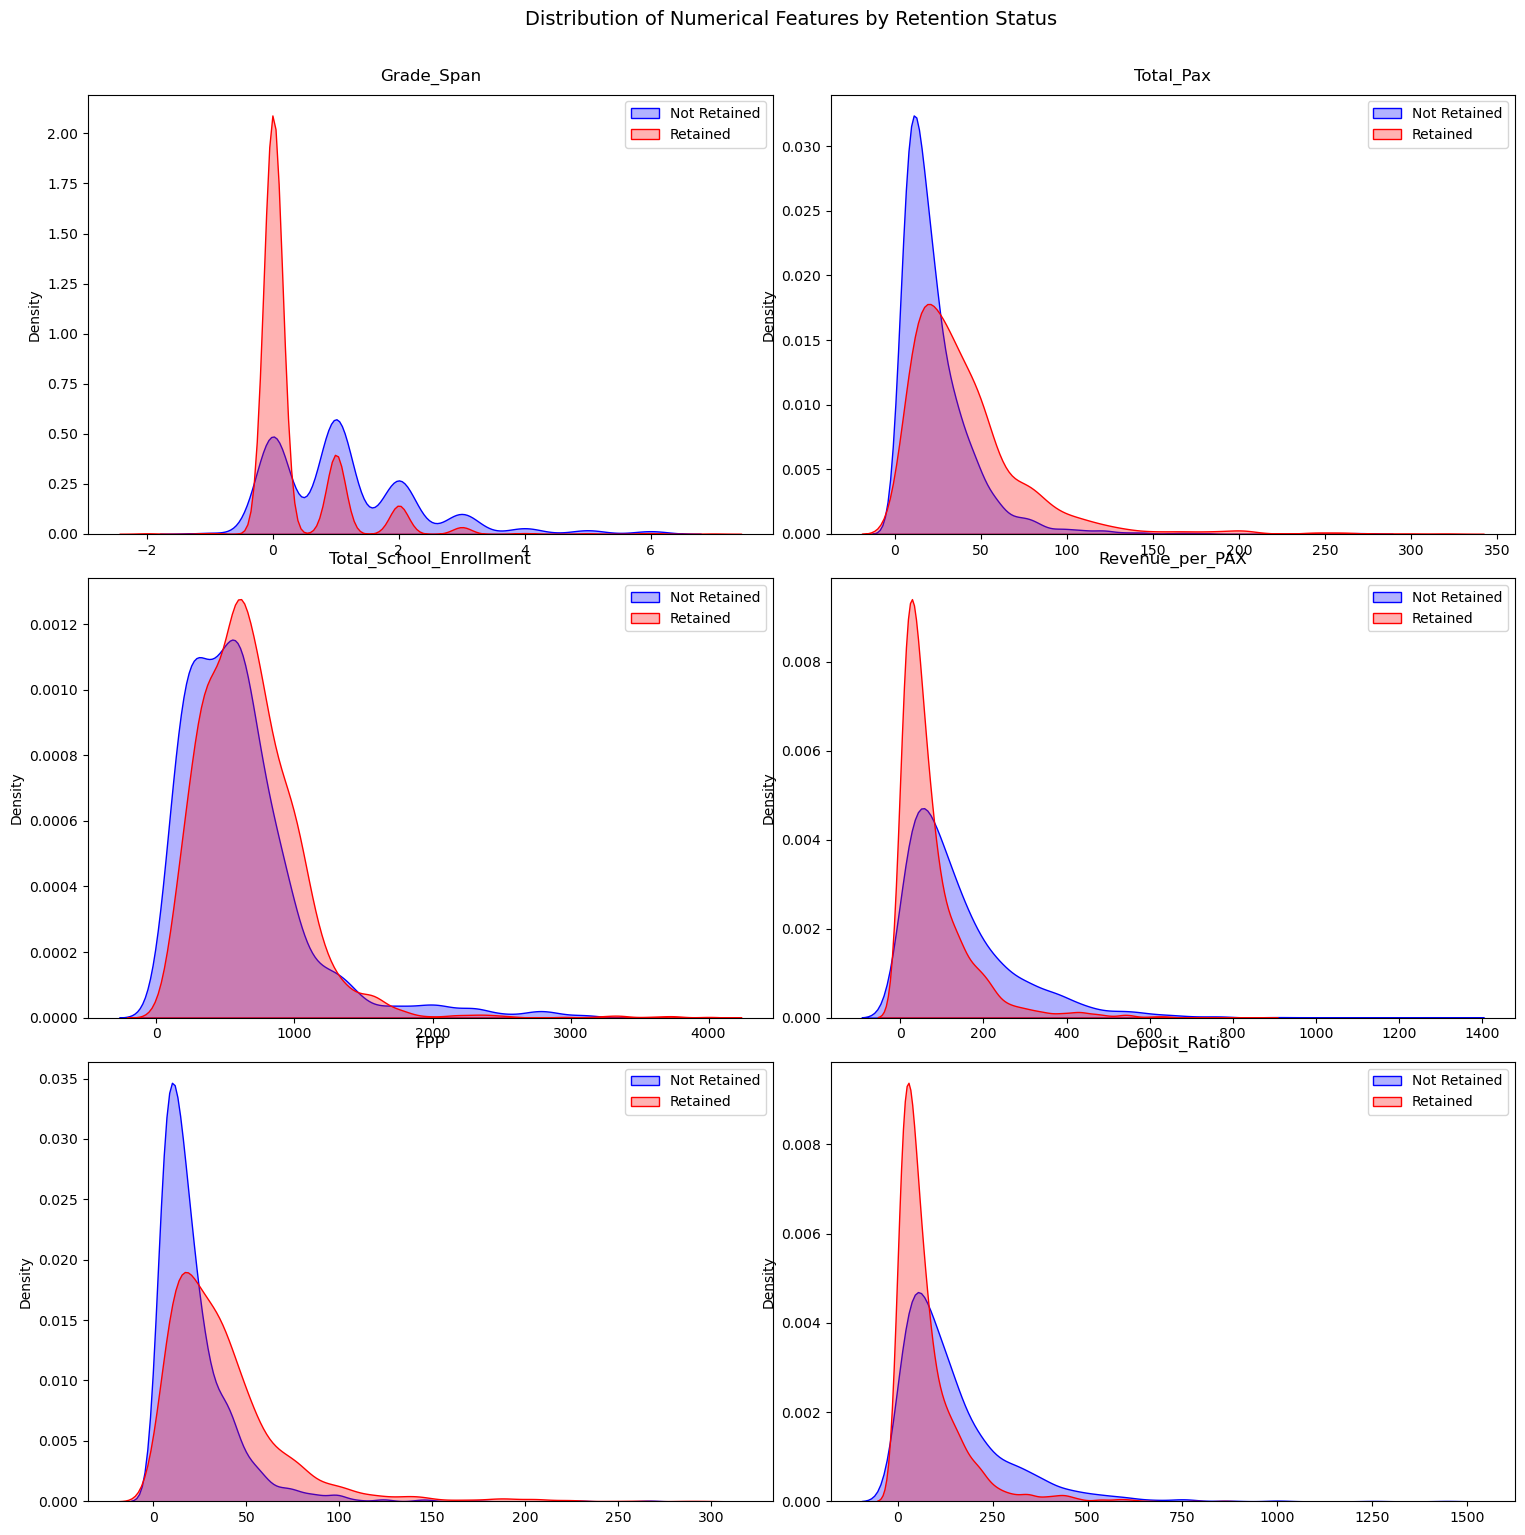

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only the columns you want to analyze
features_to_plot = ['Grade_Span', 'Total_Pax', 'Total_School_Enrollment', 'Revenue_per_PAX', 'FPP', 'Deposit_Ratio']
target = 'Retained'

# Prepare data
X = df[features_to_plot + [target]]
X0 = X[X[target] == 0]  # Not Retained
X1 = X[X[target] == 1]  # Retained

# Create subplots - adjusted for 5 features (3 rows, 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))  # Increased rows
fig.suptitle('Distribution of Numerical Features by Retention Status', y=1.02, fontsize=14)
fig.tight_layout()

# Flatten axes for easy iteration and hide the last empty subplot
axes = axes.flatten()
for ax in axes[len(features_to_plot):]:  # Hide unused subplots
    ax.set_visible(False)

# Plot each feature
for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    
    sns.kdeplot(X0[feature], color="blue", label='Not Retained', ax=ax, fill=True, alpha=0.3)
    sns.kdeplot(X1[feature], color="red", label='Retained', ax=ax, fill=True, alpha=0.3)
    
    ax.set_title(feature, pad=10)
    ax.set_xlabel('')
    ax.legend()

plt.show()

Looking at these relations, we think the company should:
-	Promote grade-specific trips: trips involving narrower grade spans (e.g., max one grade) tend to have higher retention rates. Thath's probably because homogeneous groups allow for more tailored and enjoyable experiences, making the organization smoother for teachers and schools.
-	Encourage larger group sizes: retained trips are more common among larger groups. The company could incentivize this by offering, for example, group discounts.
-	Prioritize larger schools: schools with higher enrollment appear more likely to retain trips. These institutions often have more stable budgets, established trip planning processes, and dedicated coordinators—making them ideal long-term partners.
-	Adjust pricing strategies: retained trips tend to have slightly lower revenue per participant. This suggests that affordability is a key factor. Therefore the company should offer cost-effective packages to maintain customer satisfaction and loyalty.
-   Optimize full-paying participant targets: trips with larger numbers of full-paying participants show better retention rates. 
-   Reconsider deposit policies: lower deposit ratios correlate with higher retention rates. This indicates that when schools don't need to commit large upfront payments relative to the total cost, they're more likely to book again.

Instead, what if we were in a situation where we had to **minimize False Negatives**? \
In some business scenarios, missing a repeat booking (false negative) could be far more costly than a little wasted effort (false positive). In these cases, we should prioritize recall by using the F2 score (which weights recall 4× more than precision) as our optimization metric. \
Example: a prestigious school’s annual international trip generates €50k in revenue. Missing their rebooking (FN) costs far more than preparing unnecessarily for a €5k local trip (FP). 


Let's try then to train our best model, the Random Forest, prioritizing the Recall.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, fbeta_score

# Model - Adjusted class weights to prioritize recall
classifier = RandomForestClassifier(random_state=42)  # Upweight class 1

# F2 scorer (beta=2 emphasizes recall)
f2_scorer = make_scorer(fbeta_score, beta=2)  # Correct

# Parameters
parameters = {   
    'n_estimators': [100, 200],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'criterion': ['gini'],
    'bootstrap': [True, False], 
    'max_features': ['log2', 'sqrt']
}

# GridSearchCV with F2
gs = GridSearchCV(classifier, parameters, cv=5, scoring=f2_scorer, verbose=10, n_jobs=-1)
gs.fit(X_train, y_train)

# Best model
best_model = gs.best_estimator_

# Predictions
y_probs = best_model.predict_proba(X_test)[:, 1]  

# Thresholds
y_pred_default = best_model.predict(X_test)  # Default threshold (0.5)
y_pred_adjusted = (y_probs > 0.4).astype(int)  # Lower threshold for RECALL

# Results
print("\n*** GRIDSEARCH RESULTS ***")
print(f"Best parameters: {gs.best_params_}")

print("\n*** MODEL EVALUATION (Default Threshold=0.5) ***")
print(f"F2 Score: {fbeta_score(y_test, y_pred_default, beta=2):.4f}")  
print("Classification Report:\n", classification_report(y_test, y_pred_default))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_default))

print("\n*** MODEL EVALUATION (Adjusted Threshold=0.4) ***")
print(f"F2 Score: {fbeta_score(y_test, y_pred_adjusted, beta=2):.4f}")  
print("Classification Report:\n", classification_report(y_test, y_pred_adjusted))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 1/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 1/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 1/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 5/5; 1/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 2/8] START bootstrap=True, criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 2/5; 2/8] START bootstrap=True, criterion=gini, max_depth=None, ma

# PREDICTIONS ON UNLABELED DATA

In [ ]:
predict_df = pd.read_csv('./df_unlabelled_clean.csv')
id_sales = predict_df['ID_SALES'].copy()

predict_df = pd.get_dummies(predict_df, columns = ['Program_Code'], drop_first=True)
predict_df['Group_State_encoded'] = predict_df['Group_State'].map(predict_df['Group_State'].value_counts(normalize=True))
predict_df = predict_df.drop(columns=['Group_State'])
predict_df = pd.get_dummies(predict_df, columns=['Travel_Type'], dtype=int, drop_first=True)
predict_df = pd.get_dummies(predict_df, columns=['SPR_Product_Type'], dtype=int, drop_first=True)
predict_df = pd.get_dummies(predict_df, columns=['MajorProgramCode'], dtype=int, drop_first=True)
predict_df = pd.get_dummies(predict_df, columns=['Region'], dtype=int, drop_first=True)
predict_df = pd.get_dummies(predict_df, columns=['School_Type'], dtype=int, drop_first=True)

# Select numerical features
predict_df_clean = predict_df.select_dtypes(include=['number']).copy()
X_predict = predict_df_clean

# Standardization (with original fitted Scaler)
X_predict = scaler.transform(X_predict)

# Predictions
predictions = best_model_forest.predict(X_predict)
y_probs = best_model_forest.predict_proba(X_predict)[:, 1]  
new_threshold = 0.6 
y_pred_adjusted = (y_probs > new_threshold).astype(int)

# New df
results_df = pd.DataFrame({
    'ID_SALES': id_sales,
    'Retained': y_pred_adjusted,
})

print(results_df.head())
print(f"Number of ones: {np.count_nonzero(y_pred_adjusted == 1)}")
print(f"Number of zeros: {np.count_nonzero(y_pred_adjusted == 0)}")

results_df.to_csv('predictions_retained.csv', index=False)

  ID_SALES  Retained
0  HS1005A         1
1  CC1040A         1
2  HD1261A         0
3  HD1480A         1
4  HD1939A         0
Number of ones: 342
Number of zeros: 285
